In [1]:
#import data to spark dataframe
user_profile   = spark.read.csv("/FileStore/tables/user_profile.csv",header=True,inferSchema=True)

In [2]:
# There are two duplicated column in original dataset.
# variable: vopenid0	vopenid and dtstatdate	dtstatdate0
# I checked the value of those two groups. Confirmed both of them populated same value.
# So I will ignore those two variable dtstatdate0 and vopenid0 in my following analysis.
# Unique Key of Table User_Profile is combination of  'user_id' and 'dtstatdate'.

File "<command-801549922797868>" , line 1 
 There are two duplicated column in original dataset. 
 ^
 SyntaxError : invalid syntax

In [3]:
from pyspark.sql import SQLContext
user_profile.createOrReplaceTempView("user_profile_sql")

In [4]:
#Fisrt task I am doing here is checking what's unique key of user_profile table.
#Due to 'vgameappid' and 'vopenid' will not change since registered. 
#I assume that this two variable could point out who is our new user. I am going to verify it now.

File "<command-801549922797870>" , line 1 
 Fisrt task I am doing here is checking what's unique key of user_profile table. 
 ^
 SyntaxError : invalid syntax

In [5]:
sqlContext.sql("select vgameappid,vopenid,dregdate,dtstatdate,count(*) as cnt from user_profile_sql group by 1,2,3,4 order by count(*) desc").show()
# Well, The assumption is correct. The highest cnt is one. 
# I am going to create a new variable which will be used as a unique user id which consist of vgameappid,vopenid,dregdate.

+----------+-------------------+--------+----------+---+
vgameappid| vopenid|dregdate|dtstatdate|cnt|
+----------+-------------------+--------+----------+---+
 TPFB_1320|rInyXGqKtatadbnbhbh|20181005| 20181008| 1|
 UG_1230| 50432131051985931|20181006| 20181006| 1|
 PG| 50016543966627212|20181002| 20181009| 1|
 BF| QHXyWLTJJXfPqaQYqs|20181007| 20181028| 1|
 BF| oFVhMpALnIcgTQrdc|20181004| 20181015| 1|
 CG| 50344900390421900|20181005| 20181023| 1|
 BF| 50423118657095052|20181006| 20181020| 1|
 BF| EUicxKoYZBXsBIEOAx|20181007| 20181010| 1|
 UG_1230| 50027727333268491|20181006| 20181024| 1|
 BF| UxgZhpDntAMspZYilt|20181005| 20181005| 1|
 UG_1230| 50476433773861899|20181007| 20181032| 1|
 BF| avhZztBbHFVyTyWlt|20181001| 20181008| 1|
 BF| 50397312882967948|20181006| 20181006| 1|
 PG| 50394250168632716|20181006| 20181009| 1|
 BF| 50250165961229708|20181004| 20181013| 1|
 BF| 49942176473679244|20181001| 20181001| 1|
 BF| tSQnBHorCKOaVDaAfr|20181001| 20181008| 1|
 BF| 50238521768019340|20181004| 20181030| 1|
 BF| 49871285756757388|20181001| 20181024| 1|
 BF| 50449046636463500|20181007| 20181010| 1|
+----------+-------------------+--------+----------+---+
only showing top 20 rows

In [6]:
 user_login_dt = sqlContext.sql("select user_id, min(dtstatdate) as first_login_dt_since_registered from user_profile_sql_3 group by 1")

In [7]:
user_active_register_flag = sqlContext.sql("select is_actived_in_day_one, count(*) as num_user from (select concat(concat(vgameappid,vopenid),dregdate) as user_id, max(case when dregdate = dtstatdate then 1 else 0 end) as is_actived_in_day_one from user_profile_sql group by 1)sub group by 1")

In [8]:
user_active_register = sqlContext.sql('''
select A.*, 
B.is_actived_in_day_one 
from 
  (select concat(concat(vgameappid,vopenid),dregdate) as user_id
  , count(*) as num_session 
  from user_profile_sql 
  group by 1
  ) A 
left join 
  (select concat(concat(vgameappid,vopenid),dregdate) as user_id
  , max(case when dregdate = dtstatdate then 1 else 0 end) as is_actived_in_day_one 
  from user_profile_sql 
  group by 1
  )B on A.user_id = B.user_id 
''')

In [9]:
user_active_register_flag.display()

is_actived_in_day_one,num_user
1,29917
0,126712


In [10]:
user_active_register.createOrReplaceTempView("user_active_register")
user_active_register_v1 = sqlContext.sql('''
select is_actived_in_day_one
, num_session
, count(*) as num_users 
from user_active_register 
group by 1,2
''')

In [11]:
user_active_register_v2 = sqlContext.sql('''
select concat(concat(vgameappid,vopenid),dregdate) as user_id, 
count(*) as num_session 
from user_profile_sql 
group by 1
''')

In [12]:
user_active_register_v2.createOrReplaceTempView("user_active_register_v2")
sqlContext.sql('''
select num_session
, count(*) as cnt_customers 
from user_active_register_v2 
group by num_session
''').show()

+-----------+-------------+
num_session|cnt_customers|
+-----------+-------------+
 19| 11|
 7| 1375|
 6| 1661|
 9| 858|
 17| 33|
 5| 2046|
 1| 129189|
 10| 649|
 3| 4767|
 12| 253|
 8| 1023|
 11| 605|
 2| 10078|
 4| 3124|
 13| 440|
 14| 220|
 15| 209|
 20| 11|
 16| 77|
+-----------+-------------+

In [13]:
display(user_active_register_v1)

is_actived_in_day_one,num_session,num_users
1,13,231
0,4,2332
1,7,528
1,11,319
1,12,99
1,15,110
0,8,616
0,17,11
0,14,88
0,9,473


In [14]:
#look into the distribution of active user by days.
user_active_days = sqlContext.sql('''select concat(concat(vgameappid,vopenid),dregdate) as user_id,count(*) as total_active_days from user_profile_sql group by 1''')

In [15]:
user_profile_sql_2.filter(user_profile_sql_2.user_id=='BF2747568432283790020181003').show()

In [16]:
# Clean up the variable systemhardware. It consist of device brand and the device type. For device brand, there is Tencent virtual machine. It could be recoginzed as a benchmark of our analysis. 
# Create a variable which indicate # of login time for the current day 

In [17]:
# User_profile_sql_2: 
# 1) created user_id based on the unique key in the dataset.
# 2) substring the brand of the systerm hardware
# 3) substring the device type of the systerm hardware
user_profile_sql_2 = sqlContext.sql("select concat(concat(vgameappid,vopenid),dregdate) as user_id,dregdate,platid,vgameappid,vopenid,country,systemhardware,SUBSTRING_INDEX(systemhardware, '+', 1) as brand, SUBSTRING_INDEX(systemhardware, '+', -1) as device_type, network,memory,deviceid,dtstatdate,ionlinetime,ilogincount,platform,top10times,killingcount,survivaltime,itimes,iamount,cc,variant from user_profile_sql")
user_profile_sql_2.createOrReplaceTempView("user_profile_sql_2")

In [18]:
#look into the distribution of active user by days.
user_active_days = sqlContext.sql("select concat(concat(vgameappid,vopenid),dregdate) as user_id,count(*) as total_active_days from user_profile_sql group by 1")
user_active_days.createOrReplaceTempView("user_active_days")
user_active_dist = sqlContext.sql("select total_active_days, count(*) as cnt_user from user_active_days group by 1 order by 1")
display(user_active_dist)

total_active_days,cnt_user
1,129189
2,10078
3,4767
4,3124
5,2046
6,1661
7,1375
8,1023
9,858
10,649


In [19]:
#quality check the variable total_active_days created correctly.
user_active_days.filter(user_active_days.user_id=='BF2747568432283790020181003').show()

+--------------------+-----------------+
 user_id|total_active_days|
+--------------------+-----------------+
BF274756843228379...| 1|
+--------------------+-----------------+

In [20]:
#user_profile_sql_3: Add number of active days in the user table
user_active_days.createOrReplaceTempView("user_active_days")
user_profile_sql_2.toPandas()
user_profile_sql_3 = user_profile_sql_2.join(user_active_days,on='user_id')
user_profile_sql_3.createOrReplaceTempView("user_profile_sql_3") 

In [21]:
len(user_profile_sql_3.toPandas()['user_id'].value_counts())

In [22]:
user_online_time_1 = sqlContext.sql("select user_id, dtstatdate,ionlinetime,ifnull(lead(ionlinetime,1) over(partition by user_id order by dtstatdate desc),0) as prev_online_time from user_profile_sql_3 order by 1,2 ")
user_online_time_1.createOrReplaceTempView("user_online_time_1")
user_online_time_2 = sqlContext.sql("select *, case when (ionlinetime - prev_online_time) < 0 then 1 else 0 end as ind_invalid_online_time from user_online_time_1 order by user_id")
user_online_time_2.createOrReplaceTempView("user_online_time_2")

In [23]:
# user_profile_sql_4: Clean up the ionlinetime
#As the data dictionary, the ionline time should be the total online time since user_account be created so it should be monotonic ranking ordered. I appended the previous total online time into the existing record. If the #previous online time is higher than current online time, I will create a alert flag.

In [24]:
#Once a user had a invalid record in his total time online, I will assume this customer become a invalid customer.
sqlContext.sql("select * from user_online_time_2 where user_id in ('BF2597659552295220320181006','BF2709314762480167620181006')").show()

+--------------------+----------+-----------+----------------+-----------------------+
 user_id|dtstatdate|ionlinetime|prev_online_time|ind_invalid_online_time|
+--------------------+----------+-----------+----------------+-----------------------+
BF259765955229522...| 20181008| 34771.0| 0.0| 0|
BF259765955229522...| 20181010| 17131.0| 34771.0| 1|
BF270931476248016...| 20181012| 26709.0| 0.0| 0|
BF270931476248016...| 20181015| 11424.0| 26709.0| 1|
+--------------------+----------+-----------+----------------+-----------------------+

In [25]:
#user_online_time_3: Creating invalid online time flag in customer level
user_online_time_3= sqlContext.sql("select user_id, max(ind_invalid_online_time) as max_invalid_flag from user_online_time_2 group by 1")
user_online_time_3.createOrReplaceTempView("user_online_time_3")

In [26]:
sqlContext.sql("select max_invalid_flag, count(user_id) as num_user from (select user_id, max(ind_invalid_online_time) as max_invalid_flag from user_online_time_2 group by 1)sub group by 1 ").show()
# Total number of user is 156,629.
# In user level, 21,309 users have at least one invalid 'online total time'. 
# Those 21,309 users are about 13.6% of total population.
# Meanwhile, some user online be actived to use our platform once.

+----------------+--------+
max_invalid_flag|num_user|
+----------------+--------+
 1| 21309|
 0| 135320|
+----------------+--------+

In [27]:
user_online_time_2.show()

+--------------------+----------+-----------+----------------+-----------------------+
 user_id|dtstatdate|ionlinetime|prev_online_time|ind_invalid_online_time|
+--------------------+----------+-----------+----------------+-----------------------+
BF101484359533213...| 20181004| 10194.0| 0.0| 0|
BF101484359633213...| 20181004| 10194.0| 0.0| 0|
BF101658617093830...| 20181013| 9472.0| 0.0| 0|
BF101658617193830...| 20181013| 9472.0| 0.0| 0|
BF103757140799010...| 20181025| 3488.0| 0.0| 0|
BF103757140899010...| 20181025| 3488.0| 0.0| 0|
BF105560835803068...| 20181006| 1194.0| 0.0| 0|
BF105560835903068...| 20181006| 1194.0| 0.0| 0|
BF107501990564345...| 20181010| 4055.0| 0.0| 0|
BF107501990664345...| 20181010| 4055.0| 0.0| 0|
BF107962817067104...| 20181021| 6080.0| 0.0| 0|
BF107962817167104...| 20181021| 6080.0| 0.0| 0|
BF108221401612957...| 20181020| 900.0| 0.0| 0|
BF108221401712957...| 20181020| 900.0| 0.0| 0|
BF109114403160078...| 20181003| 8078.0| 0.0| 0|
BF109114403260078...| 20181003| 8078.0| 0.0| 0|
BF111729461107111...| 20181030| 38.0| 0.0| 0|
BF111729461207111...| 20181030| 38.0| 0.0| 0|
BF111878940061874...| 20181029| 5393.0| 0.0| 0|
BF111878940161874...| 20181029| 5393.0| 0.0| 0|
+--------------------+----------+-----------+----------------+-----------------------+
only showing top 20 rows

In [28]:
#user_profile_sql_4: 
#1. Adding online time on current day.
user_profile_sql_4 = sqlContext.sql("select A.*,A.dtstatdate-A.dregdate as days_after_registered, B.ionlinetime-B.prev_online_time as today_online_time, B.prev_online_time,B.ind_invalid_online_time,C.max_invalid_flag from user_profile_sql_3 A left join user_online_time_2 B on A.user_id = B.user_id and A.dtstatdate=B.dtstatdate left join user_online_time_3 C on A.user_id = C.user_id" )
user_profile_sql_4.createOrReplaceTempView("user_profile_sql_4")

In [29]:
sqlContext.sql("select itimes, case when iamount>0 then 1 else 0 end as ind_paid, count(*) from user_profile_sql_4 group by 1,2 order by 2 asc").show()

+------+--------+--------+
itimes|ind_paid|count(1)|
+------+--------+--------+
 18| 0| 11|
 4| 0| 22|
 2| 0| 33|
 1| 0| 143|
 3| 0| 22|
 0| 0| 251813|
 6| 1| 2|
 3| 1| 8|
 1| 1| 54|
 18| 1| 2|
 0| 1| 77|
 5| 1| 4|
 4| 1| 4|
 2| 1| 12|
+------+--------+--------+

In [30]:
user_profile_sql_4.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252207 entries, 0 to 252206
Data columns (total 29 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 user_id 252207 non-null object 
 1 dregdate 252207 non-null int32 
 2 platid 252207 non-null int32 
 3 vgameappid 252207 non-null object 
 4 vopenid 252207 non-null object 
 5 country 252207 non-null object 
 6 systemhardware 252207 non-null object 
 7 brand 252207 non-null object 
 8 device_type 252207 non-null object 
 9 network 252207 non-null object 
 10 memory 252207 non-null float64
 11 deviceid 252207 non-null object 
 12 dtstatdate 252207 non-null int32 
 13 ionlinetime 252207 non-null float64
 14 ilogincount 252207 non-null int32 
 15 platform 252207 non-null int32 
 16 top10times 252207 non-null int32 
 17 killingcount 252207 non-null float64
 18 survivaltime 252207 non-null float64
 19 itimes 252207 non-null int32 
 20 iamount 252207 non-null int32 
 21 cc 252207 non-null float64
 22 variant 252207 non-null object 
 23 total_active_days 252207 non-null int64 
 24 days_after_registered 252207 non-null int32 
 25 today_online_time 252207 non-null float64
 26 prev_online_time 252207 non-null float64
 27 ind_invalid_online_time 252207 non-null int32 
 28 max_invalid_flag 252207 non-null int32 
dtypes: float64(7), int32(11), int64(1), object(10)
memory usage: 45.2+ MB

In [31]:
user_profile_cleaned = user_profile_sql_4.toPandas()

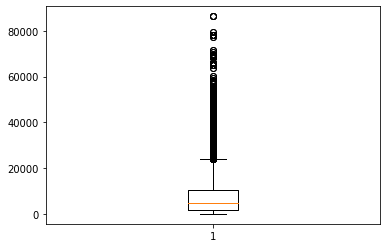

In [32]:
time_fliter = user_profile_cleaned[user_profile_cleaned["ind_invalid_online_time"]== 0]
data = time_fliter.loc[:,'today_online_time']
data

plt.figure()
plt.boxplot(data)

In [33]:
%python
time_fliter['today_online_time'].describe()
time_fliter['today_online_time'].quantile(0.1)

Out[74]: 367.0

In [34]:
display(today_online_time)

today_online_time,num_users
2815.0,17
5776.0,24
10024.0,15
1761.0,45
11430.0,24
-1848.0,11
2734.0,13
2862.0,17
10930.0,24
-1551.0,11


In [35]:
user_profile_sql_4.toPandas().head(5)

,user_id,dregdate,platid,vgameappid,vopenid,country,systemhardware,brand,device_type,network,memory,deviceid,dtstatdate,ionlinetime,ilogincount,platform,top10times,killingcount,survivaltime,itimes,iamount,cc,variant,total_active_days,days_after_registered,today_online_time,prev_online_time,ind_invalid_online_time,max_invalid_flag
0,BF2569034621032999620181001,20181001,1,BF,25690346210329996,尼泊尔,Tencent+virtual machine 2,Tencent,virtual machine 2,Wifi,3.0,f656925c9e0ef2c7,20181002,2748.0,5,1,3,2.0,2142.0,0,0,3.0,B,1,1,2748.0,0.0,0,0
1,BF2747568432283790020181003,20181003,1,BF,27475684322837900,印度尼西亚,OPPO+CPH1803,OPPO,CPH1803,Wifi,2.0,5e00c6f12c52e406,20181031,476.0,3,1,0,-0.0,1.0,0,0,-0.0,Control,1,28,476.0,0.0,0,0
2,BF3317461676812020420181007,20181007,0,BF,33174616768120204,乌兹别克斯坦,"Apple+iPhone12,3",Apple,"iPhone12,3",Wifi,3.0,59555A38-3051-4DFC-BA75-D9C2AE664C36,20181030,5441.0,13,0,3,9.0,7730.0,0,0,14.0,Control,1,23,5441.0,0.0,0,0
3,BF3748607532925070020181006,20181006,1,BF,37486075329250700,印度,vivo+vivo 1818,vivo,vivo 1818,4G,5.0,ff1d134fb11810ec,20181034,17861.0,8,1,6,13.0,11083.0,0,0,13.0,C,1,28,17861.0,0.0,0,0
4,BF4279733001064346720181001,20181001,1,BF,42797330010643467,印度,realme+RMX1971,realme,RMX1971,4G,7.0,abe6d81f8e727558,20181022,3032.0,5,1,1,13.0,1683.0,0,0,1.0,B,1,21,3032.0,0.0,0,0


In [36]:
sqlContext.sql("select variant,mean(iamount) as ave_spending from user_profile_sql_4 where brand != 'Tencent' group by variant").show()

+-------+-------------------+
variant| ave_spending|
+-------+-------------------+
 B| 0.3745488831810645|
 C| 0.4365961728855923|
 A|0.42402635253290677|
Control|0.27785676564975426|
+-------+-------------------+

In [37]:
amount_fliter = user_profile_cleaned[user_profile_cleaned["brand"] != 'Tencent']

In [38]:
amount = amount_fliter.loc[:,['iamount','variant']]
amount

,iamount,variant
1,0.0,Control
2,0.0,Control
3,0.0,C
4,0.0,B
5,0.0,B
...,...,...
252201,0.0,C
252202,0.0,C
252203,0.0,B
252204,0.0,B


In [39]:
amount.groupby("variant")['iamount'].mean()

Out[206]: variant
A 0.503451
B 0.451317
C 0.498111
Control 0.331243
Name: iamount, dtype: float64

In [40]:
A_iamount= amount[amount["variant"]=='A']['iamount'].mean()
B_iamount=amount[amount["variant"]=='B']['iamount'].mean()
C_iamount=amount[amount["variant"]=='C']['iamount'].mean()
Control_iamount=amount[amount["variant"]=='Control']['iamount'].mean()

n=online_time.variant.count()
print("Avg for A:",A_iamount,'\n',
      "Avg for B:",B_iamount,'\n',
      "Avg for C:",C_iamount,'\n',
      "Avg for Control:",Control_iamount,'\n',
      "No. of total cases",n)

Avg for A: 0.5034508051878772 
 Avg for B: 0.45131734250905237 
 Avg for C: 0.49811109556457256 
 Avg for Control: 0.33124328645299894 
 No. of total cases 204795

In [41]:
z_score_group_A, p_value_group_A = sm.stats.proportions_ztest([A_iamount,Control_iamount],[n_A, n_control],alternative='larger')
print("Avg for A:",z_score_group_A, p_value_group_A)
norm.cdf(z_score_group_A)

Avg for A: 0.005682145942001554 0.4977331639384712
Out[212]: 0.5022668360615288

In [42]:
z_score_group_B, p_value_group_B = sm.stats.proportions_ztest([B_iamount,Control_iamount],[n_B, n_control],alternative='larger')
print("Avg for A:",z_score_group_B, p_value_group_B)
norm.cdf(z_score_group_B)

Avg for A: 0.037719037388901235 0.48495584857776275
Out[213]: 0.5150441514222373

In [43]:
z_score_group_C, p_value_group_C = sm.stats.proportions_ztest([C_iamount,Control_iamount],[n_C, n_control],alternative='larger')
print("Avg for A:",z_score_group_C, p_value_group_C)
norm.cdf(z_score_group_C)

Avg for A: 0.0828014282999948 0.4670047167052421
Out[214]: 0.5329952832947579

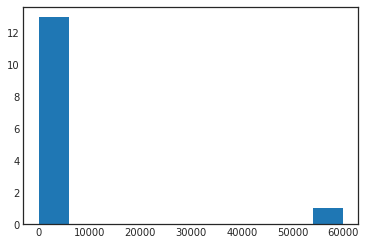

In [44]:
# check the distribution of different variants
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
variation_A = amount[amount['variant']=='A']
plt.hist(variation_A.groupby('iamount')['variant'].count())

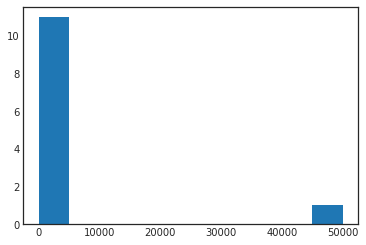

In [45]:
# check the distribution of different variants
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
variation_B = amount[amount['variant']=='B']
plt.hist(variation_B.groupby('iamount')['variant'].count())

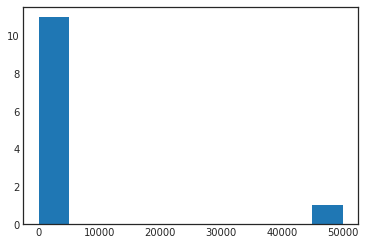

In [46]:
# check the distribution of different variants
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
variation_C = amount[amount['variant']=='C']
plt.hist(variation_C.groupby('iamount')['variant'].count())

In [47]:
sqlContext.sql("select variant,mean(today_online_time) as ave_online_time from user_profile_sql_4 group by variant").show()

+-------+-----------------+
variant| ave_online_time|
+-------+-----------------+
 B|4551.468042250841|
 C|4516.273345809807|
 A|4541.300639687029|
Control|4535.537796633691|
+-------+-----------------+

In [48]:
online_time = time_fliter.loc[:,['today_online_time','variant']].where()
online_time

,today_online_time,variant
0,2748.0,B
1,476.0,Control
2,5441.0,Control
3,17861.0,C
4,3032.0,B
...,...,...
252202,6625.0,C
252203,54.0,B
252204,14947.0,B
252205,20674.0,A


In [49]:
A_onlinetime=online_time[online_time["variant"]=='A']['today_online_time'].mean()
B_onlinetime=online_time[online_time["variant"]=='B']['today_online_time'].mean()
C_onlinetime=online_time[online_time["variant"]=='C']['today_online_time'].mean()
Control_onlinetime=online_time[online_time["variant"]=='Control']['today_online_time'].mean()

n=online_time.variant.count()
print("Avg for A:",A_onlinetime.,'\n',
      "Avg for B:",B_onlinetime,'\n',
      "Avg for C:",C_onlinetime,'\n',
      "Avg for Control:",Control_onlinetime,'\n',
      "No. of total cases",n)

Avg for A: 7372.051457669031 
 Avg for B: 7396.76933294267 
 Avg for C: 7374.150668334245 
 Avg for Control: 7370.487622070313 
 No. of total cases 204795

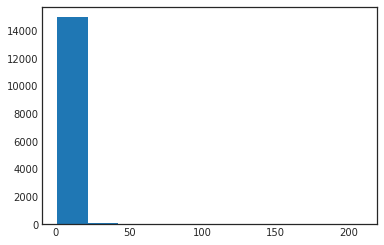

In [50]:
# check the distribution of different variants
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

variation_A = online_time[online_time['variant']=='A']

plt.hist(variation_A.groupby('today_online_time')['variant'].count())

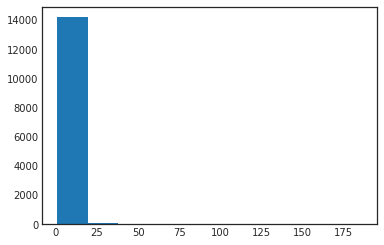

In [51]:
# check the distribution of different variants
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
variation_B = online_time[online_time['variant']=='B']
plt.hist(variation_B.groupby('today_online_time')['variant'].count())

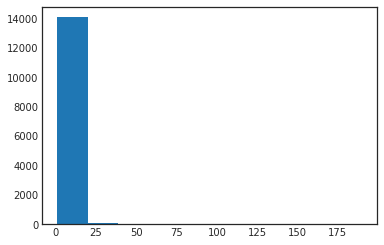

In [52]:
plt.style.use('seaborn-white')
variation_C = online_time[online_time['variant']=='C']
plt.hist(variation_C.groupby('today_online_time')['variant'].count())

In [53]:
online_time = time_fliter.loc[:,['today_online_time','variant']].where()
online_time

In [54]:
n_control = online_time[online_time["variant"]=='Control']['variant'].count()
n_A = online_time[online_time["variant"]=='A']['variant'].count()
n_B = online_time[online_time["variant"]=='B']['variant'].count()
n_C = online_time[online_time["variant"]=='C']['variant'].count()

In [55]:
#first a function for calculating probability of z test
import statsmodels.api as sm
from scipy.stats import norm

z_score_group_C, p_value_group_C = sm.stats.proportions_ztest([C_onlinetime,Control_onlinetime],[n_C, n_control],alternative='larger')
print("Avg for C:",z_score_group_C, p_value_group_C)
norm.cdf(z_score_group_C)

Avg for C: -14.743392814982935 1.0
Out[177]: 1.6965069213116667e-49

In [56]:
z_score_group_B, p_value_group_B = sm.stats.proportions_ztest([B_onlinetime,Control_onlinetime],[n_B, n_control],alternative='larger')
print("Avg for B:",z_score_group_B, p_value_group_B)
norm.cdf(z_score_group_B)

Avg for B: -14.58215330905844 1.0
Out[178]: 1.8241264388187246e-48

In [57]:
z_score_group_A, p_value_group_A = sm.stats.proportions_ztest([A_onlinetime,Control_onlinetime],[n_A, n_control],alternative='larger')
print("Avg for A:",z_score_group_A, p_value_group_A)
norm.cdf(z_score_group_A)

Avg for A: -26.803428050222294 1.0
Out[179]: 1.4736047664868022e-158

In [58]:
user_profile_cleaned = user_profile_sql_4.toPandas()

In [59]:
user_profile_cleaned['Paid_Session'] = np.where(user_profile_cleaned['iamount']>0,1,0)

In [60]:
# 'dtstatdate' is the day when the user logined. If one user logined in after registered, the user should have at least two record in the database which one record for registered day and the other record for the day after registerded. However, I found a edge case which aganist the assumption. 
sqlContext.sql("select ind_play_at_day_one, count(user_id) as cnt_customer from (select user_id, min(case when dregdate = dtstatdate then 1 else 0 end) as ind_play_at_day_one from user_profile_sql_4)sub group by 1").show()

In [61]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [62]:
user_profile_cleaned.columns

Out[223]: Index(['user_id', 'dregdate', 'platid', 'vgameappid', 'vopenid', 'country',
 'systemhardware', 'brand', 'device_type', 'network', 'memory',
 'deviceid', 'dtstatdate', 'ionlinetime', 'ilogincount', 'platform',
 'top10times', 'killingcount', 'survivaltime', 'itimes', 'iamount', 'cc',
 'variant', 'total_active_days', 'days_after_registered',
 'today_online_time', 'prev_online_time', 'ind_invalid_online_time',
 'max_invalid_flag'],
 dtype='object')

In [63]:
print(user_profile_cleaned['ipaid'].value_counts())

0 252066
1 141
Name: ipaid, dtype: int64

In [64]:
pd.options.display.max_rows = 999
user_profile_cleaned.groupby('brand')['ipaid'].sum()

Out[245]: brand
10or 0
360 0
A-gold 0
A1 0
ACE France 0
ADVAN 0
ARK 0
AlcatelOneTouch 0
Amazon 0
Amlogic 0
Apple 37
Axiom 0
BLU 0
BQru 0
Benzo 0
BlackBerry 0
Blackview 0
BluewaveGlobal 0
CASPER 0
CLARESTA 0
CLARMIN 0
CMDC 0
COMIO 0
CUBOT 0
Casper 0
Cherry_Mobile 0
Coolpad 0
DOOGEE 0
Dell Inc. 0
Droi 0
ELEVATE 0
EXCEED 0
Elephone 0
Energizer 0
Essential Products 0
FERO 0
FUJITSU 0
Fly 0
FortunaPix 0
Fortune Ship 0
Foxconn 0
Foxconn International Holdings Limited 0
FreeBit 0
GIONEE 0
GOME 0
General Mobile 0
GiONEE 0
Gigabyte Technology Co., Ltd. 0
Google 0
Gree 0
HIKING 0
HMD Global 11
HOMETECH 0
HOTWAV 0
HTC 0
HUAWEI 17
Haier 0
Hewlett-Packard 0
Hipstreet 0
Hisense 0
Hoffmann 0
Hometech 0
Huawei 0
IKU 0
INFINIX MOBILITY LIMITED 0
ITEL MOBILE LIMITED 0
InFocus 0
Infinix 0
Intex 0
JOYAR 0
KENBO 0
KONKA 0
KYOCERA 0
Kalley 0
Karbonn 0
LAVA 0
LEAGOO 0
LENOVO 2
LG 0
LG Electronics 0
LGE 0
LT 0
LYF 0
Lava 0
LeMobile 0
Lenovo 0
Letv 0
Longcheer 0
M626HDD02 0
MAX 0
MLS 0
MOBIWIRE 0
MSI 0
Masstel 0
Meitu 0
Meizu 0
Micromax 0
NUU 0
Netease 0
OPPO 10
OUKITEL 0
OnePlus 0
P30 0
P30 pro 0
PANASONIC 0
PANTECH 0
Philips 0
Plus One Japan Limited 0
Posh 0
Premier Air 2 0
Prestigio 0
QMobile 0
Qtouch 0
Quanta 0
Realme 0
Reliance 0
SDQ-55024L GREY 0
SHARP 0
SONY 0
SOP 0
SPA Condor Electronics 0
SPRINT4G 0
SPURT 0
STG 0
SUGAR 0
Samsung 0
Sharp 0
Skyworth 0
Smartron 0
Sony 2
Starlight 0
Symphony 0
T106Q 0
TCL 0
TECNO 0
TECNO MOBILE LIMITED 0
TOSHIBA 0
TP-LINK 0
TP-Link 0
TURKCELL 0
Techain 0
Teclast 0
Tencent 0
Tesla 0
Titan 0
To be filled by O.E.M. 0
Turkcell 0
UMIDIGI 0
Ulefone 0
Vestel 0
VjVj 0
Vodafone 0
WALTON 0
WIKO 0
Walton 0
XTOUCH 0
XiaoMi 0
Xiaomi 23
YU 0
YuLong 0
Yulong 0
ZEN 0
ZOPO 0
ZTE 0
ZUK 0
Zuk 0
alps 0
amzn 0
asus 0
benzo 0
blackberry 0
blackshark 0
bnd 0
bq 0
condor 0
coolpad 0
deltainno 0
fluo 0
generalmobile 0
google 0
htc 0
huawei 0
i23ht546v0 0
iBall 0
iPhone 0
iVOOMi 0
incar 0
itel 0
koobee 0
l76k3t866a 0
lenovo 0
m2082c4q71 0
malata 0
meizu 0
mobiistar 0
motorola 0
myphone 0
nubia 0
p5o550f1s2 0
realme 2
reeder 0
revoview 0
rockchip 0
samsung 16
techain 0
ulefone 0
unknown 0
vivo 21
vmos 0
vsmart 0
wheatek 0
xiaolajiao 0
xiaomi 0
zte 0
Name: ipaid, dtype: int64

In [65]:
user_profile_cleaned_v1 = user_profile_cleaned.drop(user_profile_cleaned[(user_profile_cleaned['brand']=='Tencent')|(user_profile_cleaned['max_invalid_flag']==1)].index)

In [66]:
user_profile_cleaned_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139260 entries, 1 to 252205
Data columns (total 30 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 user_id 139260 non-null object 
 1 dregdate 139260 non-null int32 
 2 platid 139260 non-null int32 
 3 vgameappid 139260 non-null object 
 4 vopenid 139260 non-null object 
 5 country 139260 non-null object 
 6 systemhardware 139260 non-null object 
 7 brand 139260 non-null object 
 8 device_type 139260 non-null object 
 9 network 139260 non-null object 
 10 memory 139260 non-null float64
 11 deviceid 139260 non-null object 
 12 dtstatdate 139260 non-null int32 
 13 ionlinetime 139260 non-null float64
 14 ilogincount 139260 non-null int32 
 15 platform 139260 non-null int32 
 16 top10times 139260 non-null int32 
 17 killingcount 139260 non-null float64
 18 survivaltime 139260 non-null float64
 19 itimes 139260 non-null int32 
 20 iamount 139260 non-null int32 
 21 cc 139260 non-null float64
 22 variant 139260 non-null object 
 23 total_active_days 139260 non-null int64 
 24 days_after_registered 139260 non-null int32 
 25 today_online_time 139260 non-null float64
 26 prev_online_time 139260 non-null float64
 27 ind_invalid_online_time 139260 non-null int32 
 28 max_invalid_flag 139260 non-null int32 
 29 Paid_Session 139260 non-null int64 
dtypes: float64(7), int32(11), int64(2), object(10)
memory usage: 27.1+ MB

In [67]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
user_profile_cleaned_v1['vgameappid_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['vgameappid'])
user_profile_cleaned_v1['country_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['country'])
user_profile_cleaned_v1['brand_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['brand'])
user_profile_cleaned_v1['network_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['network'])
user_profile_cleaned_v1['variant_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['variant'])
user_profile_cleaned_v1['vopenid_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['vopenid'])
user_profile_cleaned_v1['device_type_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['device_type'])
#user_profile_cleaned_v1['user_id_end'] = labelencoder.fit_transform(user_profile_cleaned_v1['user_id'])

user_profile_cleaned_v2 = user_profile_cleaned_v1.drop(columns=['vgameappid','network','variant','brand','country','vopenid','systemhardware','deviceid','device_type','user_id'])
user_profile_cleaned_v2

,dregdate,platid,memory,dtstatdate,ionlinetime,ilogincount,platform,top10times,killingcount,survivaltime,itimes,iamount,cc,total_active_days,days_after_registered,today_online_time,prev_online_time,ind_invalid_online_time,max_invalid_flag,Paid_Session,country_end,brand_end,network_end,variant_end,vopenid_end,device_type_end,vgameappid_end
1,20181003,1,2.0,20181031,476.0,3,1,0,-0.0,1.0,0,0,-0.0,1,28,476.0,0.0,0,0,0,32,99,6,3,2844,277,0
2,20181007,0,3.0,20181030,5441.0,13,0,3,9.0,7730.0,0,0,14.0,1,23,5441.0,0.0,0,0,0,5,10,6,3,3230,2407,0
3,20181006,1,5.0,20181034,17861.0,8,1,6,13.0,11083.0,0,0,13.0,1,28,17861.0,0.0,0,0,0,31,206,3,2,3774,2510,0
4,20181001,1,7.0,20181022,3032.0,5,1,1,13.0,1683.0,0,0,1.0,1,21,3032.0,0.0,0,0,0,31,198,3,1,13763,1338,0
5,20181006,1,1.0,20181032,9585.0,10,1,2,3.0,2479.0,0,0,9.0,1,26,9585.0,0.0,0,0,0,69,99,3,1,13902,286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252201,20181005,1,3.0,20181016,7619.0,9,1,2,10.0,2913.0,0,0,3.0,1,11,7619.0,0.0,0,0,0,134,55,6,2,66531,109,22
252202,20181006,1,7.0,20181028,6625.0,3,1,0,-0.0,1.0,0,0,-0.0,1,22,6625.0,0.0,0,0,0,162,99,6,2,75551,1240,22
252203,20181007,0,2.0,20181033,54.0,24,0,8,-0.0,9951.0,0,0,10.0,1,26,54.0,0.0,0,0,0,31,202,6,1,99973,1485,22
252204,20181002,0,2.0,20181023,14947.0,1,0,0,5.0,4982.0,0,0,-0.0,1,21,14947.0,0.0,0,0,0,12,156,6,1,106304,1389,22


In [68]:
user_profile_cleaned_v2_sp = sqlContext.createDataFrame(user_profile_cleaned_v2)
train_PS_data, test_PS_data = user_profile_cleaned_v2_sp.randomSplit([0.7, 0.3])

In [69]:
user_profile_cleaned_v2_sp.columns

Out[136]: ['dregdate',
 'platid',
 'memory',
 'dtstatdate',
 'ionlinetime',
 'ilogincount',
 'platform',
 'top10times',
 'killingcount',
 'survivaltime',
 'itimes',
 'iamount',
 'cc',
 'total_active_days',
 'days_after_registered',
 'today_online_time',
 'prev_online_time',
 'ind_invalid_online_time',
 'max_invalid_flag',
 'Paid_Session',
 'vgameappid_end',
 'country_end',
 'brand_end',
 'network_end',
 'variant_end',
 'vopenid_end',
 'device_type_end']

In [70]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [72]:
user_profile_cleaned_v2.columns

Out[139]: Index(['dregdate', 'platid', 'memory', 'dtstatdate', 'ionlinetime',
 'ilogincount', 'platform', 'top10times', 'killingcount', 'survivaltime',
 'itimes', 'iamount', 'cc', 'total_active_days', 'days_after_registered',
 'today_online_time', 'prev_online_time', 'ind_invalid_online_time',
 'max_invalid_flag', 'Paid_Session', 'vgameappid_end', 'country_end',
 'brand_end', 'network_end', 'variant_end', 'vopenid_end',
 'device_type_end'],
 dtype='object')

In [73]:
pd.options.display.max_columns = 999
corrMatrix = user_profile_cleaned_v2.corr()
print (corrMatrix.cc)

dregdate -0.005075
platid 0.040905
memory 0.015683
dtstatdate 0.072614
ionlinetime 0.601663
ilogincount 0.250156
platform 0.040905
top10times 0.639919
killingcount 0.429540
survivaltime 0.646619
itimes 0.021478
iamount 0.014592
cc 1.000000
total_active_days -0.004187
days_after_registered 0.075812
today_online_time 0.607234
prev_online_time 0.008139
ind_invalid_online_time NaN
max_invalid_flag NaN
Paid_Session 0.018858
country_end -0.028592
brand_end 0.036791
network_end -0.072013
variant_end 0.000579
vopenid_end 0.007758
device_type_end -0.019570
vgameappid_end -0.098841
Name: cc, dtype: float64

In [74]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['dregdate', 'platid', 'memory', 'dtstatdate', 'ionlinetime',
       'ilogincount', 'platform', 'top10times', 'killingcount', 'survivaltime',
       'itimes', 'iamount', 'total_active_days', 'days_after_registered',
       'today_online_time', 'prev_online_time', 'ind_invalid_online_time',
       'max_invalid_flag', 'vgameappid_end', 'country_end',
       'brand_end', 'network_end', 'variant_end', 'vopenid_end',
       'device_type_end'], outputCol='features')

assembler_2 = VectorAssembler(inputCols=['platid', 'ionlinetime',
       'ilogincount', 'platform', 'top10times', 'killingcount', 'survivaltime',
       'itimes', 'iamount', 'total_active_days', 'days_after_registered',
       'today_online_time', 'country_end',
       'brand_end', 'vgameappid_end'], outputCol='features')

feature_list = []
for col in user_profile_cleaned_v2.columns:
    if col == 'cc':
        continue
    else:
        feature_list.append(col)


In [75]:
#HYPERPARAMETER GRID
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

rf = RandomForestRegressor(featuresCol="features",labelCol="cc")

pipeline_rf = Pipeline(stages=[assembler_2,rf])

#cross-validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)


In [76]:
fit_model = pipeline_rf.fit(train_PS_data)
results = fit_model.transform(test_PS_data)

In [77]:
results.select("features","cc", "prediction").show(5)

+--------------------+---+-----------------+
 features| cc| prediction|
+--------------------+---+-----------------+
[0.0,5157.0,3.0,0...|3.0|4.443387821836698|
[0.0,5424.0,8.0,0...|4.0|4.538744149787643|
[0.0,1898.0,1.0,0...|1.0|2.395868739749134|
[0.0,1898.0,1.0,0...|1.0|2.395868739749134|
[0.0,14847.0,3.0,...|8.0|6.761085794237775|
+--------------------+---+-----------------+
only showing top 5 rows

In [78]:
evaluator = RegressionEvaluator(labelCol="cc", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(results)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.15218

In [79]:
print(classification_report(y_test, y_pred))

In [80]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2046267390299067> in <module> 
 ----> 1 bestPipeline = cvModel . bestModel
 2 bestModel = bestPipeline . stages [ 1 ] 
 3 
 4 importances = bestModel . featureImportances
 5 

 NameError : name 'cvModel' is not defined

In [81]:
%pip install mlflow

Python interpreter will be restarted.
Requirement already satisfied: mlflow in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (1.11.0)
Requirement already satisfied: docker>=4.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (4.3.1)
Requirement already satisfied: protobuf>=3.6.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (3.13.0)
Requirement already satisfied: alembic<=1.4.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.7/site-packages (from mlflow) (2.8.1)
Requirement already satisfied: click>=7.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (7.1.2)
Requirement already satisfied: sqlparse in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (0.3.1)
Requirement already satisfied: gorilla in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (0.3.0)
Requirement already satisfied: querystring-parser in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.7/site-packages (from mlflow) (1.14.0)
Requirement already satisfied: azure-storage-blob>=12.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (12.5.0)
Requirement already satisfied: databricks-cli>=0.8.7 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (0.12.0)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.7/site-packages (from mlflow) (2.22.0)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (20.0.4)
Requirement already satisfied: Flask in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (1.1.2)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.7/site-packages (from mlflow) (1.0.1)
Requirement already satisfied: pyyaml in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (5.3.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from mlflow) (1.18.1)
Requirement already satisfied: gitpython>=2.1.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (3.1.8)
Requirement already satisfied: prometheus-flask-exporter in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (0.18.0)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.7/site-packages (from mlflow) (0.3)
Requirement already satisfied: sqlalchemy<=1.3.13 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (1.3.13)
Requirement already satisfied: cloudpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: websocket-client>=0.32.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-db173698-da61-456b-8354-62521a5a7067/lib/python3.7/site-packages (from docker>=4.0.0->mlflow) (0.57.0)
Requireme

In [82]:
import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt

from numpy import savetxt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

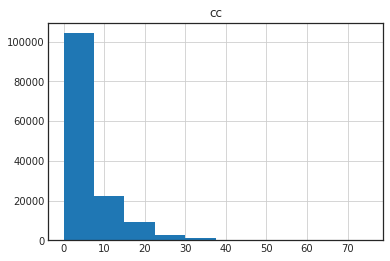

In [83]:
user_profile_cleaned_v2.hist(column = 'cc')

In [85]:
import seaborn as sns
sns.pairplot(user_profile_cleaned_v2)

In [86]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression
# Define LinearRegression algorithm
lr = LinearRegression(featuresCol="features",labelCol="cc")
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[assembler_2, lr])
model = pipeline.fit(train_PS_data)

In [87]:
def modelsummary(model):
    import numpy as np
    print ("Note: the last rows are the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   |   Std.Error | t Values  |  P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:10.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:8.3f}'.format(Summary.tValues[i]),\
        '{:10.6f}'.format(Summary.pValues[i]))

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" % Summary.r2, ", \
            Total iterations: %i"% Summary.totalIterations)
    
    
modelsummary(model.stages[-1])

# Make predictions.
predictions = model.transform(test_PS_data)

Note: the last rows are the information for Intercept
## -------------------------------------------------
## Estimate | Std.Error | t Values | P-value
## -2.770000 1276986.385143 -0.000 1.000000
## -0.000055 0.000014 -3.839 0.000124
## 0.023054 0.001210 19.046 0.000000
## 2.906320 1276986.385143 0.000 1.000000
## 0.482633 0.005079 95.016 0.000000
## 0.030685 0.001002 30.622 0.000000
## 0.000401 0.000005 85.709 0.000000
## 0.430943 0.142716 3.020 0.002532
## -0.000087 0.000427 -0.203 0.838830
## 0.325333 0.039084 8.324 0.000000
## 0.026355 0.001761 14.962 0.000000
## 0.000247 0.000015 16.939 0.000000
## 0.002115 0.000283 7.484 0.000000
## 0.000701 0.000219 3.203 0.001360
## -0.016096 0.002069 -7.778 0.000000
## -0.358562 0.067324 -5.326 0.000000
## ---
## Mean squared error: 19.690202 , RMSE: 4.437364
## Multiple R-squared: 0.545831 , Total iterations: 1

In [88]:
%python
temp_df[temp_df['itimes']> 0]['user_id'].nunique()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-610563733524673> in <module> 
 ----> 1 temp_df [ temp_df [ 'itimes' ] > 0 ] [ 'user_id' ] . nunique ( ) 

 NameError : name 'temp_df' is not defined

In [89]:
# Try to understand how customer convert to a paid customer.
sqlContext.sql("select ind_converted,count(*) as num_user from (select user_id, max(case when itimes >0 then 1 else 0 end) as ind_converted from user_profile_sql_4 group by user_id)sub group by 1").show()

+-------------+--------+
ind_converted|num_user|
+-------------+--------+
 1| 317|
 0| 156312|
+-------------+--------+

In [90]:
user_profile_sql_4.createOrReplaceTempView("user_profile_sql_4")
df_paid_customer = sqlContext.sql("select user_id, max(case when itimes >0 then 1 else 0 end) as ind_converted from user_profile_sql_4 group by user_id")

In [91]:
actived_user_reg_info = sqlContext.sql("select case when itimes >0 then 1 else 0 end as ind_converted,variant,platid,vgameappid,platform,count(*) as cnt from user_profile_sql_4 where dregdate = dtstatdate and ind_invalid_online_time = 0 group by 1,2,3,4,5")

In [92]:
display(actived_user_reg_info)

ind_converted,variant,platid,vgameappid,platform,cnt
0,B,1,JPKRFB_1320,1,211
0,C,1,JPKRTW_1320,1,46
0,A,0,VNGFB_1320,0,52
0,A,1,CG,1,47
0,C,1,BF,1,2584
0,Control,0,VNGFB_1320,0,26
0,C,0,VNGFB_1320,0,28
0,B,0,UG_1230,0,270
0,Control,0,CG,0,66
0,B,0,JPKRFB_1320,0,31


In [93]:
actived_user_onl_act = sqlContext.sql("select case when itimes >0 then 1 else 0 end as ind_converted,top10times,cc,float(mean(today_online_time)) as average_online_time,count(*) as cnt from user_profile_sql_4 where dregdate = dtstatdate and ind_invalid_online_time = 0 group by 1,2,3")

In [94]:
display(actived_user_onl_act)

ind_converted,top10times,cc,average_online_time,cnt
0,4,3.0,6305.25,88
0,2,13.0,6661.5415,24
0,17,9.0,6621.0,11
0,1,14.0,4303.0,22
0,1,5.0,5528.8335,108
0,9,5.0,7153.75,44
0,15,0.0,10432.0,22
0,6,14.0,12409.63,27
0,11,6.0,12127.333,33
0,4,11.0,20136.781,32


In [95]:
df_paid_customer = sqlContext.sql("select * from user_profile_sql_4 where itimes >0").toPandas()

In [96]:
#Paid Customer not inculding any 

In [97]:
df_paid_customer = spark.createDataFrame(df_paid_customer)

In [98]:
df_paid_customer.write.csv(path='/FileStore/tables/paid_customer.csv', header=True, sep=",", mode='overwrite')

In [99]:
dbfs cp dbfs:/FileStore/tables/paid_customer.csv ./Users/haohanzhao/Downloads/paid_customer.csv

File "<command-3938246988336118>" , line 1 
 dbfs cp dbfs:/FileStore/tables/paid_customer.csv ./Users/haohanzhao/Downloads/paid_customer.csv 
 ^
 SyntaxError : invalid syntax

In [101]:
sqlContext.sql("select case when itimes >0 then 1 else 0 end as ind_converted, variant,total_active_days, days_after_registered,ionlinetime,count(*) as cnt from user_profile_sql_4 group by 1,2,3,4,5,6,7")

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-1578537429677133> in <module> 
 ----> 1 sqlContext . sql ( "select case when itimes >0 then 1 else 0 end as ind_converted, variant,total_active_days, days_after_registered,ionlinetime,count(*) as cnt from user_profile_sql_4 group by 1,2,3,4,5,6,7" ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : GROUP BY position 7 is not in select list (valid range is [1, 6]); line 1 pos 185

In [102]:
user_profile_sql_4.createOrReplaceTempView("user_profile_sql_4")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1578537429677129> in <module> 
 ----> 1 user_profile_sql_4 . createOrReplaceTempView ( "user_profile_sql_4" ) 

 NameError : name 'user_profile_sql_4' is not defined

In [103]:
user_profile_sql_4.toPandas().head(5)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1578537429677130> in <module> 
 ----> 1 user_profile_sql_4 . toPandas ( ) . head ( 5 ) 

 NameError : name 'user_profile_sql_4' is not defined

In [104]:
sqlContext.sql("select variant,mean(today_online_time) as avg_online_time, mean(today_online_time/ilogincount) as online_per_login from user_profile_sql_4 where max_invalid_flag = 0 group by 1").show()

+-------+------------------+------------------+
variant| avg_online_time| online_per_login|
+-------+------------------+------------------+
 B|7089.2465749594585|1782.1494790054517|
 C| 7058.184095952361|1802.9014105230758|
 A| 7059.533015992121|1794.7611574349446|
Control| 7087.597362269285|1780.4888164471292|
+-------+------------------+------------------+

In [105]:
user_online_time_2.createOrReplaceTempView("user_online_time_2")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1578537429677107> in <module> 
 ----> 1 user_online_time_2 . createOrReplaceTempView ( "user_online_time_2" ) 

 NameError : name 'user_online_time_2' is not defined

In [106]:
sqlContext.sql("select total_active_user, count(*) as cnt_customer from (select user_id,count(*) as total_active_days from user_profile_sql_4 group by user_id)sub group by 1")
display(user_distribution)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-3992195877087688> in <module> 
 ----> 1 sqlContext . sql ( "select total_active_user, count(*) as cnt_customer from (select user_id,count(*) as total_active_days from user_profile_sql_4 group by user_id)sub group by 1" ) 
 2 display ( user_distribution ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`total_active_user`' given input columns: [sub.total_active_days, sub.user_id]; line 1 pos 7;
'Aggregate [unresolvedordinal(1)], ['total_active_user, count(1) AS cnt_customer#105086L]
+- SubqueryAlias sub
 +- Aggregate [user_id#101724], [user_id#101724, count(1) AS total_active_days#105085L]
 +- SubqueryAlias user_profile_sql_4
 +- Project [user_id#101724, dregdate#101467, platid#101468, vgameappid#101469, vopenid#101470, country#101471, systemhardware#101472, brand#101725, device_type#101726, network#101473, memory#101474, deviceid#101475, dtstatdate#101476, ionlinetime#101477, ilogincount#101478, platform#101480, top10times#101482, killingcount#101483, survivaltime#101484, itimes#101485, iamount#101486, cc#101487, variant#101488, total_active_days#101774L, ... 5 more fields]
 +- Join LeftOuter, (user_id#101724 = user_id#102113)
 :- Join LeftOuter, ((user_id#101724 = user_id#102087) AND (dtstatdate#101476 = dtstatdate#102100))
 : :- SubqueryAlias A
 : : +- SubqueryAlias user_profile_sql_3
 : : +- Project [user_id#101724, dregdate#101467, platid#101468, vgameappid#101469, vopenid#101470, country#101471, systemhardware#101472, brand#101725, device_type#101726, network#101473, memory#101474, deviceid#101475, dtstatdate#101476, ionlinetime#101477, ilogincount#101478, platform#101480, top10times#101482, killingcount#101483, survivaltime#101484, itimes#101485, iamount#101486, cc#101487, variant#101488, total_active_days#101774L]
 : : +- Join Inner, (user_id#101724 = user_id#101773)
 : : :- Project [concat(concat(vgameappid#101469, vopenid#101470), cast(dregdate#101467 as string)) AS user_id#101724, dregdate#101467, platid#101468, vgameappid#101469, vopenid#101470, country#101471, systemhardware#101472, substring_index(systemhardware#101472, +, 1) AS brand#101725, substring_index(systemhardware#101472, +, -1) AS device_type#101726, network#101473, memory#101474, deviceid#101475, dtstatdate#101476, ionlinetime#101477, ilogincount#101478, platform#101480, top10times#101482, killingcount#101483, survivaltime#101484, itimes#101485, iamount#101486, cc#101487, variant#101488]
 : : : +- SubqueryAlias user_profile_sql
 : : : +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#1

In [107]:
df_user_profile.info()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-801549922797876> in <module> 
 ----> 1 df_user_profile . info ( ) 

 NameError : name 'df_user_profile' is not defined

In [108]:
sqlContext.sql("select dtstatdate,count(*) as num_user from user_profile_sql group by 1 order by 1 asc").show()

+----------+--------+
dtstatdate|num_user|
+----------+--------+
 20181001| 4218|
 20181002| 6944|
 20181003| 8906|
 20181004| 10875|
 20181005| 13393|
 20181006| 15545|
 20181007| 17599|
 20181008| 14185|
 20181009| 12940|
 20181010| 11960|
 20181011| 11423|
 20181012| 10721|
 20181013| 10109|
 20181014| 8990|
 20181015| 8320|
 20181016| 7891|
 20181017| 7540|
 20181018| 7080|
 20181019| 6532|
 20181020| 6210|
+----------+--------+
only showing top 20 rows

In [109]:
temp_df.columns

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2046267390299032> in <module> 
 ----> 1 temp_df . columns

 NameError : name 'temp_df' is not defined

In [110]:
#Count daily active customers from each cohort
temp_df['returned_at'] = temp_df['dtstatdate'] - temp_df['dregdate']

grouping = temp_df.groupby('user_id')['dregdate'] 
grouping = temp_df.groupby(['dregdate', 'returned_at'])

cohort_data = grouping['user_id'].apply(pd.Series.nunique)

# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='dregdate',columns='returned_at',values='user_id')
cohort_counts

distinct_user = temp_df.groupby('dregdate').nunique('user_id').iloc[:,0] 
distinct_user.head(5)

percentage = cohort_counts.divide(distinct_user,axis=0)

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('churn_rate')
sns.heatmap(data=percentage,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuGn_r")
plt.show()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2046267390299033> in <module> 
 1 #Count daily active customers from each cohort 
 ----> 2 temp_df [ 'returned_at' ] = temp_df [ 'dtstatdate' ] - temp_df [ 'dregdate' ] 
 3 
 4 grouping = temp_df . groupby ( 'user_id' ) [ 'dregdate' ] 
 5 grouping = temp_df . groupby ( [ 'dregdate' , 'returned_at' ] ) 

 NameError : name 'temp_df' is not defined

In [112]:
display(sqlContext.sql("select dtstatdate,count(*) as num_user from user_profile_sql group by 1 order by 1 asc"))

dtstatdate,num_user
20181001,4218
20181002,6944
20181003,8906
20181004,10875
20181005,13393
20181006,15545
20181007,17599
20181008,14185
20181009,12940
20181010,11960


In [113]:
sqlContext.sql("select dtstatdate,count(*) as num_user from user_profile_sql group by 1 order by 1 asc").show()

+----------+--------+
dtstatdate|num_user|
+----------+--------+
 20181001| 4218|
 20181002| 6944|
 20181003| 8906|
 20181004| 10875|
 20181005| 13393|
 20181006| 15545|
 20181007| 17599|
 20181008| 14185|
 20181009| 12940|
 20181010| 11960|
 20181011| 11423|
 20181012| 10721|
 20181013| 10109|
 20181014| 8990|
 20181015| 8320|
 20181016| 7891|
 20181017| 7540|
 20181018| 7080|
 20181019| 6532|
 20181020| 6210|
+----------+--------+
only showing top 20 rows

In [114]:
# understand total online time, How it change with regesited_date moving.
regiestered_users_login_time = sqlContext.sql("select variant, dtstatdate-dregdate as days_after_regesitered,float(sum(ionlinetime)/count(*)) as login_time_per_user from user_profile_sql group by 1,2 order by 1,2")

In [115]:
display(regiestered_users_login_time)

variant,days_after_regesitered,login_time_per_user
A,0,5520.0186
A,1,7428.437
A,2,7604.2515
A,3,7238.439
A,4,7762.1826
A,5,7075.8213
A,6,7328.274
A,7,7347.4272
A,8,7168.4136
A,9,7347.265


In [116]:
#When the customer exit
customer_churn = sqlContext.sql("select num_days_with_us, count(*) as num_user from (select user_id, max((dtstatdate - dregdate+1)) as num_days_with_us from user_profile_sql_1 group by 1)sub group by 1 order by count(*) desc")

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-3545277914316434> in <module> 
 1 #When the customer exit 
 ----> 2 customer_churn = sqlContext . sql ( "select num_days_with_us, count(*) as num_user from (select user_id, max((dtstatdate - dregdate+1)) as num_days_with_us from user_profile_sql_1 group by 1)sub group by 1 order by count(*) desc" ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : Table or view not found: user_profile_sql_1; line 1 pos 124;
'Sort [count(1) DESC NULLS LAST], true
+- 'Aggregate [unresolvedordinal(1)], ['num_days_with_us, count(1) AS num_user#105176L]
 +- 'SubqueryAlias sub
 +- 'Aggregate [unresolvedordinal(1)], ['user_id, 'max((('dtstatdate - 'dregdate) + 1)) AS num_days_with_us#105175]
 +- 'UnresolvedRelation [user_profile_sql_1]

In [117]:
df_user_profile.systemhardware.nunique()
# system hardware could generate more variables: ios/android; phone/pad;

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-801549922797878> in <module> 
 ----> 1 df_user_profile . systemhardware . nunique ( ) 
 2 # system hardware could generate more variables: ios/android; phone/pad; 

 NameError : name 'df_user_profile' is not defined

In [118]:
# Data Clean up by device and brand

In [119]:
sqlContext.sql("select SUBSTRING_INDEX(systemhardware, '+', 1) as brand, SUBSTRING_INDEX(systemhardware, '+', -1) as device_type, count(*) as cnt from user_profile_sql group by 1,2 order by count(*) desc").show()

+-------+-----------------+----+
 brand| device_type| cnt|
+-------+-----------------+----+
Tencent|virtual machine 2|6077|
 Xiaomi| Redmi Note 8|4207|
samsung| SM-N950W|4036|
samsung| SM-A107F|4010|
 OPPO| CPH1909|3978|
 Apple| iPhone7,2|3924|
 Apple| iPhone8,1|3622|
samsung| SM-A105F|3329|
 Apple| iPhone9,3|3055|
 Xiaomi| Redmi Note 8 Pro|2958|
 Apple| iPhone9,4|2954|
 Apple| iPhone12,1|2816|
samsung| SM-G610F|2612|
 HUAWEI| STK-L21|2297|
samsung| SM-A207F|2259|
 Xiaomi| Redmi Note 7|2210|
 HUAWEI| DUB-LX1|2167|
 Xiaomi| Redmi 8|2154|
 Apple| iPhone11,8|2134|
samsung| SM-A205F|2118|
+-------+-----------------+----+
only showing top 20 rows

In [120]:
user_profile_sql.toPandas().info()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-801549922797883> in <module> 
 ----> 1 user_profile_sql . toPandas ( ) . info ( ) 

 NameError : name 'user_profile_sql' is not defined

In [121]:
sqlContext.sql("select systerm_type,count(*) as num_user from user_profile_sql group by 1").show()

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-801549922797885> in <module> 
 ----> 1 sqlContext . sql ( "select systerm_type,count(*) as num_user from user_profile_sql group by 1" ) . show ( ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`systerm_type`' given input columns: [user_profile_sql._c0, user_profile_sql.cc, user_profile_sql.country, user_profile_sql.deviceid, user_profile_sql.dregdate, user_profile_sql.dtstatdate, user_profile_sql.dtstatdate0, user_profile_sql.iamount, user_profile_sql.ilogincount, user_profile_sql.ionlinetime, user_profile_sql.itimes, user_profile_sql.killingcount, user_profile_sql.memory, user_profile_sql.network, user_profile_sql.platform, user_profile_sql.platid, user_profile_sql.survivaltime, user_profile_sql.systemhardware, user_profile_sql.top10times, user_profile_sql.variant, user_profile_sql.vgameappid, user_profile_sql.vopenid, user_profile_sql.vopenid0]; line 1 pos 7;
'Aggregate [unresolvedordinal(1)], ['systerm_type, count(1) AS num_user#105214L]
+- SubqueryAlias user_profile_sql
 +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#101479,platform#101480,dtstatdate0#101481,top10times#101482,killingcount#101483,survivaltime#101484,itimes#101485,iamount#101486,cc#101487,variant#101488] csv

In [122]:
set(user_profile_sql.toPandas().brand)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-801549922797888> in <module> 
 ----> 1 set ( user_profile_sql . toPandas ( ) . brand ) 

 NameError : name 'user_profile_sql' is not defined

In [123]:
sqlContext.sql("select brand from user_profile_sql").show()

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-801549922797886> in <module> 
 ----> 1 sqlContext . sql ( "select brand from user_profile_sql" ) . show ( ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`brand`' given input columns: [user_profile_sql._c0, user_profile_sql.cc, user_profile_sql.country, user_profile_sql.deviceid, user_profile_sql.dregdate, user_profile_sql.dtstatdate, user_profile_sql.dtstatdate0, user_profile_sql.iamount, user_profile_sql.ilogincount, user_profile_sql.ionlinetime, user_profile_sql.itimes, user_profile_sql.killingcount, user_profile_sql.memory, user_profile_sql.network, user_profile_sql.platform, user_profile_sql.platid, user_profile_sql.survivaltime, user_profile_sql.systemhardware, user_profile_sql.top10times, user_profile_sql.variant, user_profile_sql.vgameappid, user_profile_sql.vopenid, user_profile_sql.vopenid0]; line 1 pos 7;
'Project ['brand]
+- SubqueryAlias user_profile_sql
 +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#101479,platform#101480,dtstatdate0#101481,top10times#101482,killingcount#101483,survivaltime#101484,itimes#101485,iamount#101486,cc#101487,variant#101488] csv

In [124]:
days_after_registered = sqlContext.sql("select variant, dtstatdate - dregdate as days_after_registered, count(distinct user_id) as cnt from user_profile_sql group by 1,2")

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-801549922797889> in <module> 
 ----> 1 days_after_registered = sqlContext . sql ( "select variant, dtstatdate - dregdate as days_after_registered, count(distinct user_id) as cnt from user_profile_sql group by 1,2" ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`user_id`' given input columns: [user_profile_sql._c0, user_profile_sql.cc, user_profile_sql.country, user_profile_sql.deviceid, user_profile_sql.dregdate, user_profile_sql.dtstatdate, user_profile_sql.dtstatdate0, user_profile_sql.iamount, user_profile_sql.ilogincount, user_profile_sql.ionlinetime, user_profile_sql.itimes, user_profile_sql.killingcount, user_profile_sql.memory, user_profile_sql.network, user_profile_sql.platform, user_profile_sql.platid, user_profile_sql.survivaltime, user_profile_sql.systemhardware, user_profile_sql.top10times, user_profile_sql.variant, user_profile_sql.vgameappid, user_profile_sql.vopenid, user_profile_sql.vopenid0]; line 1 pos 79;
'Aggregate [unresolvedordinal(1), unresolvedordinal(2)], [variant#101488, (dtstatdate#101476 - dregdate#101467) AS days_after_registered#105216, 'count('user_id) AS cnt#105217]
+- SubqueryAlias user_profile_sql
 +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#101479,platform#101480,dtstatdate0#101481,top10times#101482,killingcount#101483,survivaltime#101484,itimes#101485,iamount#101486,cc#101487,variant#101488] csv

In [125]:
display(days_after_registered)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-801549922797890> in <module> 
 ----> 1 display ( days_after_registered ) 

 NameError : name 'days_after_registered' is not defined

In [126]:
Obs:
  everyday, each variant got same distribution split:
    A: 30%
    B: 25%
    C: 25%
    Control:20%
      
I will check customer their time of stay at app cross three variation.

File "<command-801549922797891>" , line 1 
 Obs: 
 ^
 SyntaxError : invalid syntax

In [127]:
# 1. Distribution of variant.
ionlinetime = sqlContext.sql("select variant,dtstatdate - dregdate as days_after_registered, avg(ionlinetime) as ionlinetime from user_profile_sql group by 1,2")

In [128]:
display(ionlinetime)

variant,days_after_registered,ionlinetime
Control,12,7918.549196141479
A,16,7730.277348066298
B,8,7484.134961954345
B,23,7946.053088803089
A,20,7643.473125414731
C,21,7693.218181818182
Control,2,7386.878724044538
B,26,8339.762463343108
C,6,7317.2201926270345
B,27,7910.490254872564


In [129]:
# Understand the experiment
# 1. Distribution of variant.
sqlContext.sql("select variant,systerm_type,count(*) as num_user from user_profile_sql group by 1,2 order by dtstatdate,variant").show()

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2618006987707724> in <module> 
 1 # Understand the experiment 
 2 # 1. Distribution of variant. 
 ----> 3 sqlContext . sql ( "select variant,systerm_type,count(*) as num_user from user_profile_sql group by 1,2 order by dtstatdate,variant" ) . show ( ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`systerm_type`' given input columns: [user_profile_sql._c0, user_profile_sql.cc, user_profile_sql.country, user_profile_sql.deviceid, user_profile_sql.dregdate, user_profile_sql.dtstatdate, user_profile_sql.dtstatdate0, user_profile_sql.iamount, user_profile_sql.ilogincount, user_profile_sql.ionlinetime, user_profile_sql.itimes, user_profile_sql.killingcount, user_profile_sql.memory, user_profile_sql.network, user_profile_sql.platform, user_profile_sql.platid, user_profile_sql.survivaltime, user_profile_sql.systemhardware, user_profile_sql.top10times, user_profile_sql.variant, user_profile_sql.vgameappid, user_profile_sql.vopenid, user_profile_sql.vopenid0]; line 1 pos 15;
'Sort ['dtstatdate ASC NULLS FIRST, 'variant ASC NULLS FIRST], true
+- 'Aggregate [unresolvedordinal(1), unresolvedordinal(2)], [variant#101488, 'systerm_type, count(1) AS num_user#105252L]
 +- SubqueryAlias user_profile_sql
 +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#101479,platform#101480,dtstatdate0#101481,top10times#101482,killingcount#101483,survivaltime#101484,itimes#101485,iamount#101486,cc#101487,variant#101488] csv

In [130]:
sqlContext.sql("select variant,systerm_type,count(*) as num_user from user_profile_sql group by 1,2 order by dtstatdate,variant").show()

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-801549922797892> in <module> 
 ----> 1 sqlContext . sql ( "select variant,systerm_type,count(*) as num_user from user_profile_sql group by 1,2 order by dtstatdate,variant" ) . show ( ) 

 /databricks/spark/python/pyspark/sql/context.py in sql (self, sqlQuery) 
 369 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 370 """
 --> 371 return self . sparkSession . sql ( sqlQuery ) 
 372 
 373 @ since ( 1.0 ) 

 /databricks/spark/python/pyspark/sql/session.py in sql (self, sqlQuery) 
 705 [ Row ( f1 = 1 , f2 = u'row1' ) , Row ( f1 = 2 , f2 = u'row2' ) , Row ( f1 = 3 , f2 = u'row3' ) ] 
 706 """
 --> 707 return DataFrame ( self . _jsparkSession . sql ( sqlQuery ) , self . _wrapped ) 
 708 
 709 @ since ( 2.0 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : cannot resolve '`systerm_type`' given input columns: [user_profile_sql._c0, user_profile_sql.cc, user_profile_sql.country, user_profile_sql.deviceid, user_profile_sql.dregdate, user_profile_sql.dtstatdate, user_profile_sql.dtstatdate0, user_profile_sql.iamount, user_profile_sql.ilogincount, user_profile_sql.ionlinetime, user_profile_sql.itimes, user_profile_sql.killingcount, user_profile_sql.memory, user_profile_sql.network, user_profile_sql.platform, user_profile_sql.platid, user_profile_sql.survivaltime, user_profile_sql.systemhardware, user_profile_sql.top10times, user_profile_sql.variant, user_profile_sql.vgameappid, user_profile_sql.vopenid, user_profile_sql.vopenid0]; line 1 pos 15;
'Sort ['dtstatdate ASC NULLS FIRST, 'variant ASC NULLS FIRST], true
+- 'Aggregate [unresolvedordinal(1), unresolvedordinal(2)], [variant#101488, 'systerm_type, count(1) AS num_user#105254L]
 +- SubqueryAlias user_profile_sql
 +- Relation[_c0#101466,dregdate#101467,platid#101468,vgameappid#101469,vopenid#101470,country#101471,systemhardware#101472,network#101473,memory#101474,deviceid#101475,dtstatdate#101476,ionlinetime#101477,ilogincount#101478,vopenid0#101479,platform#101480,dtstatdate0#101481,top10times#101482,killingcount#101483,survivaltime#101484,itimes#101485,iamount#101486,cc#101487,variant#101488] csv

In [132]:
user_profile_sql_4.createOrReplaceTempView("user_profile_sql_4")
df_user_profile = user_profile_sql_4.toPandas()

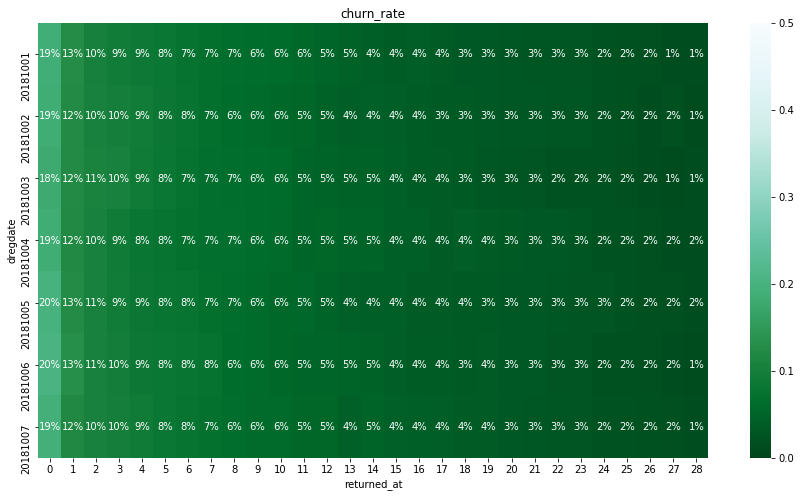

In [133]:
#Count daily active customers from each cohort
df_user_profile['returned_at'] = df_user_profile['dtstatdate'] - df_user_profile['dregdate']

grouping = df_user_profile.groupby('user_id')['dregdate'] 
grouping = df_user_profile.groupby(['dregdate', 'returned_at'])

cohort_data = grouping['user_id'].apply(pd.Series.nunique)

# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='dregdate',columns='returned_at',values='user_id')
cohort_counts

distinct_user = df_user_profile.groupby('dregdate').nunique('user_id').iloc[:,0] 
distinct_user.head(5)

percentage = cohort_counts.divide(distinct_user,axis=0)

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('churn_rate')
sns.heatmap(data=percentage,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuGn_r")
plt.show()

In [134]:
df_user_profile.columns

Out[111]: Index(['user_id', 'dregdate', 'platid', 'vgameappid', 'vopenid', 'country',
 'systemhardware', 'brand', 'device_type', 'network', 'memory',
 'deviceid', 'dtstatdate', 'ionlinetime', 'ilogincount', 'platform',
 'top10times', 'killingcount', 'survivaltime', 'itimes', 'iamount', 'cc',
 'variant', 'total_active_days', 'days_after_registered',
 'today_online_time', 'prev_online_time', 'ind_invalid_online_time',
 'max_invalid_flag', 'returned_at'],
 dtype='object')

In [135]:
sqlContext.sql("select dregdate,user_id,days_after_registered,count(*) from user_profile_sql_4 group by 1,2").show()

+--------+---------------------+--------+
dregdate|days_after_registered|count(1)|
+--------+---------------------+--------+
20181006| 17| 847|
20181006| 19| 804|
20181007| 15| 1123|
20181004| 12| 1099|
20181004| 25| 473|
20181007| 8| 1681|
20181007| 18| 922|
20181002| 20| 636|
20181002| 8| 1368|
20181004| 6| 1472|
20181004| 17| 753|
20181002| 28| 262|
20181007| 6| 2010|
20181005| 10| 1266|
20181003| 20| 596|
20181005| 0| 4335|
20181005| 28| 330|
20181005| 5| 1724|
20181005| 13| 959|
20181005| 21| 685|
+--------+---------------------+--------+
only showing top 20 rows

In [136]:
#Count daily active customers from each cohort
df_user_profile['returned_at'] = df_user_profile['dtstatdate'] - df_user_profile['dregdate']

grouping = df_user_profile.groupby('user_id')['dregdate'] 
grouping = df_user_profile.groupby(['dregdate', 'returned_at'])

cohort_data = grouping['user_id'].apply(pd.Series.nunique)

# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='dregdate',columns='returned_at',values='user_id')
cohort_counts

returned_at,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
dregdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20181001,4218,2877,2301,2094,2018,1877,1682,1542,1487,1448,1398,1300,1179,1053,964,846,890,813,742,709,690,616,658,585,512,466,418,336,311
20181002,4067,2702,2259,2138,1999,1841,1683,1491,1368,1277,1238,1159,981,919,949,866,826,734,725,689,636,636,598,608,472,426,362,405,262
20181003,3903,2686,2366,2241,1961,1774,1612,1437,1416,1353,1309,1107,1024,978,969,909,824,777,730,672,596,554,517,505,496,383,378,292,305
20181004,3836,2536,2156,1865,1675,1582,1472,1409,1388,1301,1213,1077,1099,1017,990,876,866,753,820,753,694,672,652,602,490,473,380,315,352
20181005,4335,2704,2272,2002,1854,1724,1661,1512,1436,1349,1266,1187,1076,959,902,918,799,784,760,728,718,685,662,565,553,471,383,404,330
20181006,4568,2988,2390,2194,1954,1880,1795,1715,1459,1389,1301,1186,1187,1083,1050,903,864,847,784,804,730,715,617,597,477,482,411,388,305
20181007,4990,3119,2720,2557,2382,2135,2010,1828,1681,1531,1536,1396,1371,1165,1251,1123,1073,1061,922,957,821,772,757,689,604,572,524,497,367
